In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt


from torchvision import datasets, transforms

print(torch.__version__)
print(torch.cuda.is_available())

1.6.0
True


In [2]:
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    Tensor = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    Tensor = torch.FloatTensor
    
print('using device', device)
print()

using device cuda



## Data

#### pytorch를 사용하는 김에 load도pytorch로

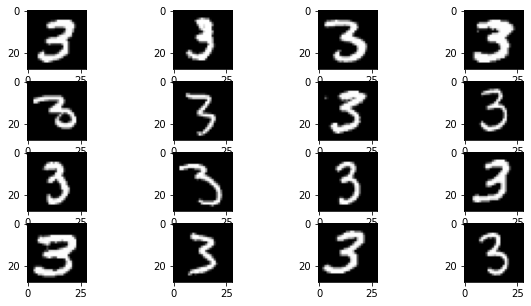

In [3]:
# transforms.Compose : 데이터를 전처리하는 패키지.

train_dataset = datasets.MNIST('../mnist_data/',
                             download=True,
                             train=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(), # image to Tensor
                                 #transforms.Normalize((0.1307,), (0.3081,)) # image, label
                             ]))

learn_label = 3
train_images = train_dataset.data[train_dataset.targets==learn_label]

fig = plt.figure(figsize=(10,5))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(np.squeeze(train_images[i]), cmap='gray')
plt.show()

### normalize data

In [4]:
train_images = (train_images - 127.5)/127.5

## Noise

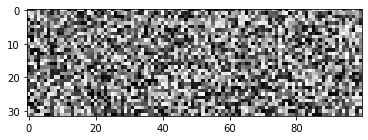

In [5]:
def create_noise(batch_size, noise_dim):
    return np.random.uniform(low=-1, high=1, size=(batch_size, noise_dim))
#     return np.random.normal(size=(batch_size, noise_dim))

noise = create_noise(32,100)
plt.imshow(noise, cmap='gray')
plt.show()

# Model

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class Generator(nn.Module):
    def __init__(self, noise_size, hidden_size, output_size):
        super().__init__()
        
        self.d1 = nn.Linear(noise_size, hidden_size)
        self.d2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.d1(x)
        out = F.relu(out)
        out = self.d2(out)
        return out
    
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super().__init__()
        
        self.flatten = nn.Flatten()
        self.d1 = nn.Linear(input_size, hidden_size1)
        self.d2 = nn.Linear(hidden_size1, hidden_size2)
        self.d3 = nn.Linear(hidden_size2, output_size)
    
    def forward(self, x, training=True):
        out = self.flatten(x)
        out = self.d1(out)
        out = F.dropout(out, training=training)
        out = F.relu(out)
        
        out = self.d2(out)
        out = F.dropout(out, training=training)
        out = F.relu(out)
        
        out = self.d3(out)
        out = torch.sigmoid(out)
        return out 

NOISE_DIM = 100
IMG_SIZE = 28*28

G = Generator(NOISE_DIM,256,IMG_SIZE).to(device=device)
D = Discriminator(IMG_SIZE, 256, 128, 1).to(device=device)

## Loss

In [8]:
binary_cross_entropy = nn.BCELoss().to(device=device)

## Optimizer

In [9]:
LEARNING_RATE = 1e-3
MOMENTUM = 0.9

G_optimizer = torch.optim.SGD(G.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
D_optimizer = torch.optim.SGD(D.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

## Train

In [10]:
def train(G,D, train_ds, EPOCHS,
          BATCH_SIZE=16,
          NOISE_DIM=100,
          show=True):
    
    IMG_SIZE = 28*28
    
    batch_iters = train_ds.shape[0]//BATCH_SIZE
    
    if show:
        test_noise = Tensor(create_noise(1,NOISE_DIM))
    
    D_loss_history=[]
    G_loss_history=[]
    
    print('train start')
    for epoch in range(EPOCHS):
        for batch in range(batch_iters):
            noises = Tensor(create_noise(BATCH_SIZE, NOISE_DIM))
            real_img = train_ds[batch*BATCH_SIZE: (batch+1)*BATCH_SIZE].to(device=device)
            
            # D
            D_optimizer.zero_grad()
    
            fake_img = G(noises)
            fake_loss = binary_cross_entropy(D(fake_img), torch.zeros((BATCH_SIZE,1)).to(device=device))
            real_loss = binary_cross_entropy(D(real_img), torch.ones((BATCH_SIZE,1)).to(device=device))
            d_loss = (real_loss + fake_loss)/2
            
            d_loss.backward()
            D_optimizer.step()
            
            # G
            G_optimizer.zero_grad()
            
            fake_img = G(noises)
            
            g_loss = binary_cross_entropy(D(fake_img), torch.ones((BATCH_SIZE,1)).to(device=device))
            g_loss.backward()
            G_optimizer.step()
            
            # history of loss
            D_loss_history.append(d_loss)
            G_loss_history.append(g_loss)
        
        if show:
            print('epoch : {}'.format(epoch+1))
            test_img = G.forward(test_noise.detach())
            test_img = test_img[0].reshape(28,28)
            plt.imshow(test_img.detach().cpu().numpy(),cmap='gray')
            plt.show()
            
    return D_loss_history, G_loss_history

train start


C:\Users\wlstj\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch : 1


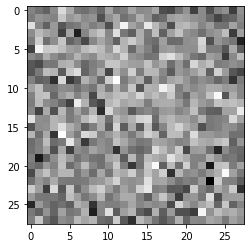

epoch : 2


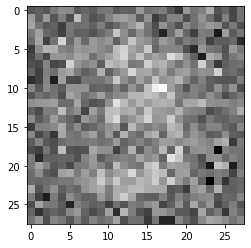

epoch : 3


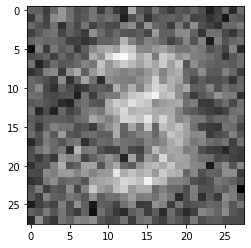

epoch : 4


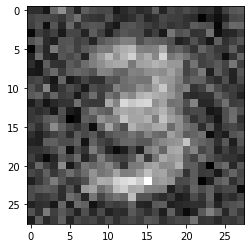

epoch : 5


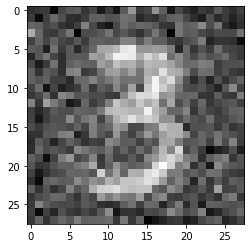

epoch : 6


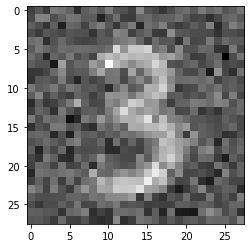

epoch : 7


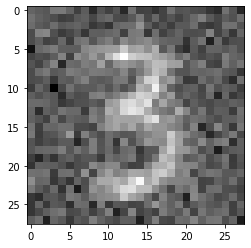

epoch : 8


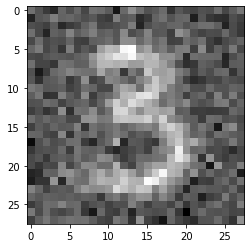

epoch : 9


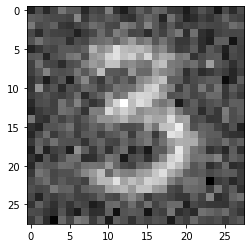

epoch : 10


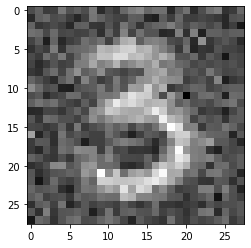

epoch : 11


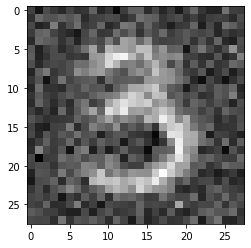

epoch : 12


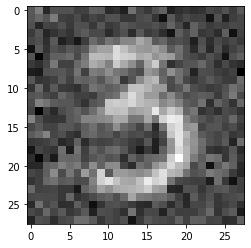

epoch : 13


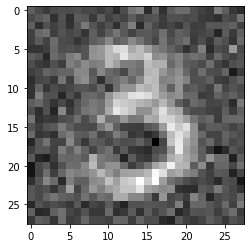

epoch : 14


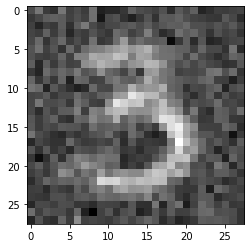

epoch : 15


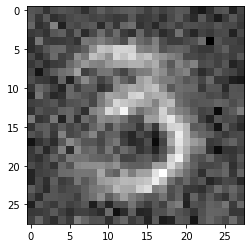

epoch : 16


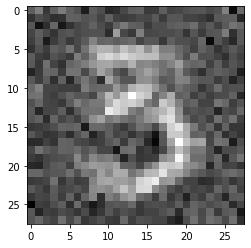

epoch : 17


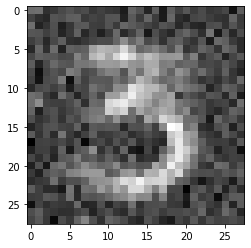

epoch : 18


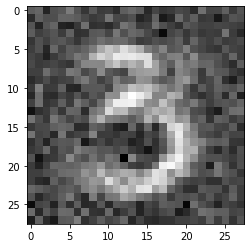

epoch : 19


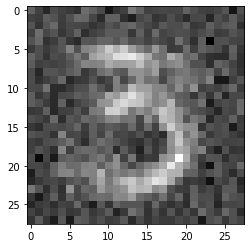

epoch : 20


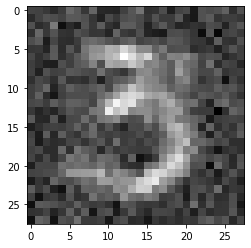

epoch : 21


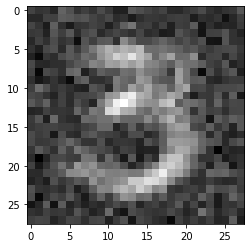

epoch : 22


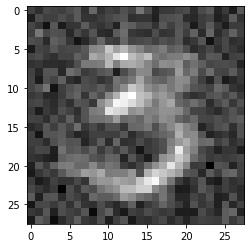

epoch : 23


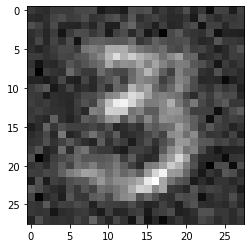

epoch : 24


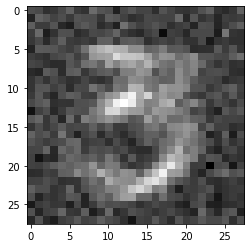

epoch : 25


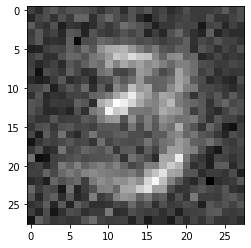

epoch : 26


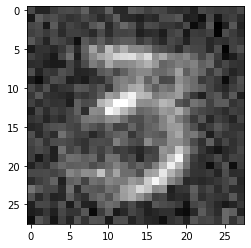

epoch : 27


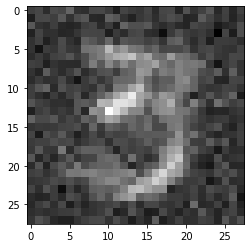

epoch : 28


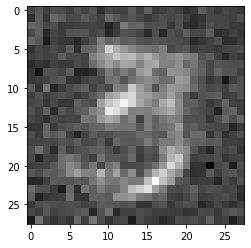

epoch : 29


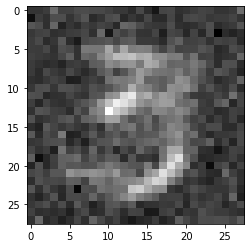

epoch : 30


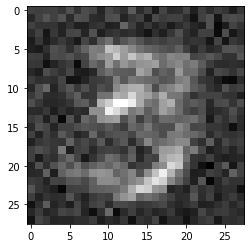

epoch : 31


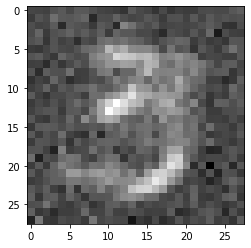

epoch : 32


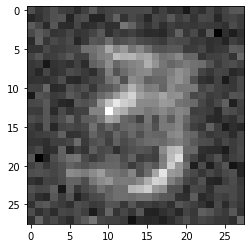

epoch : 33


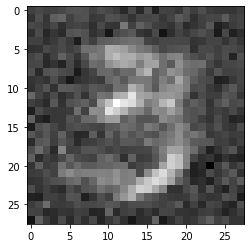

epoch : 34


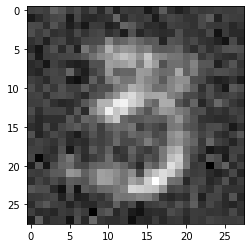

epoch : 35


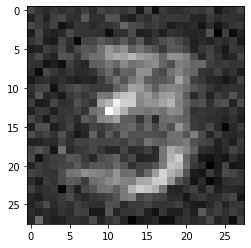

epoch : 36


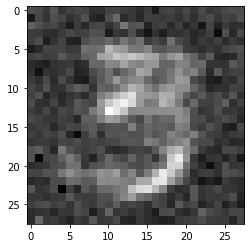

epoch : 37


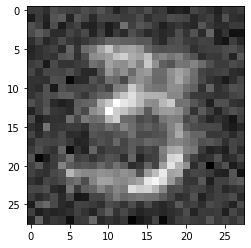

epoch : 38


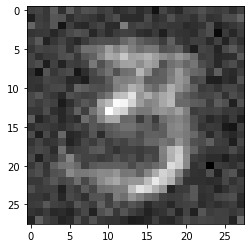

epoch : 39


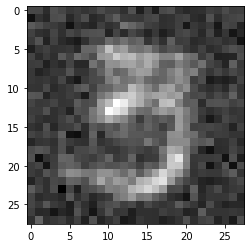

epoch : 40


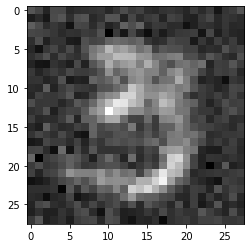

epoch : 41


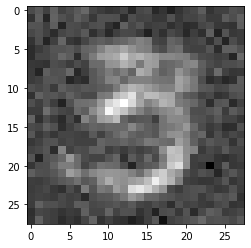

epoch : 42


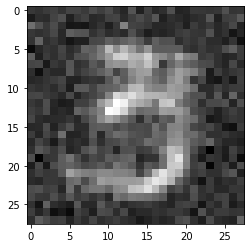

epoch : 43


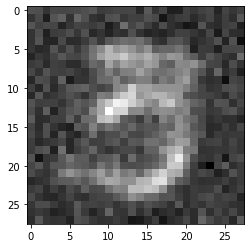

epoch : 44


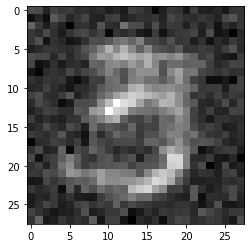

epoch : 45


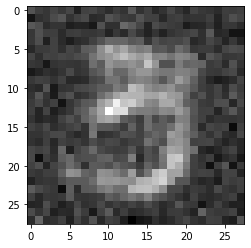

epoch : 46


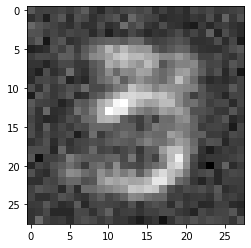

epoch : 47


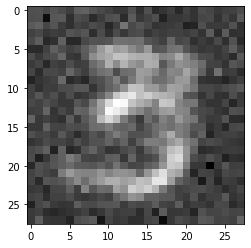

epoch : 48


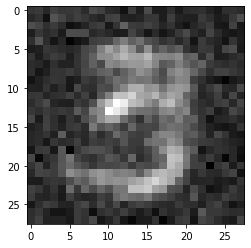

epoch : 49


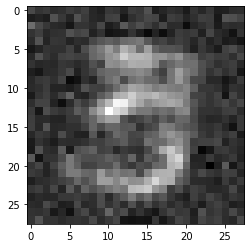

epoch : 50


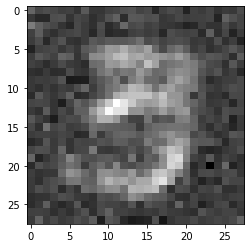

In [11]:
D_loss_history, G_loss_history = train(G, D, train_images, EPOCHS=50)

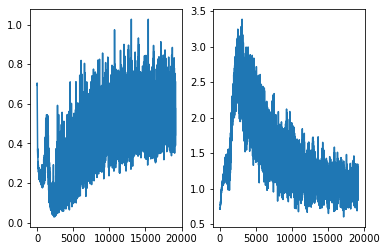

In [12]:
plt.subplot(1,2,1)
plt.plot(D_loss_history)

plt.subplot(1,2,2)
plt.plot(G_loss_history)

plt.show()

In [5]:
import torch
from torch import nn
class Generator(nn.Module):
    def __init__(self, noise_size, hidden_size, output_size):
        super().__init__()
        
        self.d1 = nn.Linear(noise_size, hidden_size)
        self.d2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.d1(x)
        out = F.relu(out)
        out = self.d2(out)
        return out
    
    def print_modules(self):
        print(self._modules)
        
G = Generator(1,2,3)
G.print_modules()

OrderedDict([('d1', Linear(in_features=1, out_features=2, bias=True)), ('d2', Linear(in_features=2, out_features=3, bias=True))])
